In [ ]:
!pip install pyod

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
#READ DATA
data = pd.read_csv('anamoly.csv')
data = data.drop(['outlier'], axis=1)

In [3]:
def setup(data, 
          target = None, 
          split = 0.7):
    
    global X, X_train, X_test, y_train, y_test, seed
    
    if target == None:
        X = data
        import random
        seed = random.randint(150,900)
        
    else:
        from sklearn.model_selection import train_test_split
        X = data.drop(target,axis=1)
        y = data[target]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-split)
        import random
        seed = random.randint(150,900)

In [4]:
def create_model(estimator = None, 
                 fraction = 0.05):

    #ignore warings
    import warnings
    warnings.filterwarnings('ignore') 

    if estimator == 'abod':
        from pyod.models.abod import ABOD
        model = ABOD(contamination=fraction)
    elif estimator == 'cluster':
        from pyod.models.cblof import CBLOF
        model = CBLOF(contamination=fraction, random_state=seed)
    elif estimator == 'cof':
        from pyod.models.cof import COF
        model = COF(contamination=fraction)        
    elif estimator == 'iforest':
        from pyod.models.iforest import IForest
        model = IForest(contamination=fraction, random_state=seed)              
    elif estimator == 'hist':
        from pyod.models.hbos import HBOS
        model = HBOS(contamination=fraction)         
    elif estimator == 'knn':
        from pyod.models.knn import KNN
        model = KNN(contamination=fraction)          
    elif estimator == 'lof':
        from pyod.models.lof import LOF
        model = LOF(contamination=fraction)      
    elif estimator == 'svm':
        from pyod.models.ocsvm import OCSVM
        model = OCSVM(contamination=fraction)
    elif estimator == 'pca':
        from pyod.models.pca import PCA
        model = PCA(contamination=fraction, random_state=seed)    
    elif estimator == 'mcd':
        from pyod.models.mcd import MCD
        model = MCD(contamination=fraction, random_state=seed)
    elif estimator == 'sod':
        from pyod.models.sod import SOD
        model = SOD(contamination=fraction)         
    elif estimator == 'sos':
        from pyod.models.sos import SOS
        model = SOS(contamination=fraction)       
    
    model.fit(X)
    return model

In [5]:
def assign_model(model):
    
    pred_labels = model.labels_
    pred_score = model.decision_scores_
    X['Label'] = pred_labels
    X['Score'] = pred_score
    return X

In [28]:
def predict_model(model, df):
       
    df_ = df.copy()
    pred_labels = model.predict(df_)
    pred_score = model.decision_function(df_)
    df_['Label'] = pred_labels
    df_['Score'] = pred_score
    return df_

In [7]:
def plot_model(model):
    pass

## Work in Progress 

In [44]:
data.head()

,0,1,2,3,4,5,6,7,8,9,Label,Score
0,0.263995,0.764929,0.138424,0.935242,0.605867,0.518790,0.912225,0.608234,0.723782,0.733591,1,-0.116896
1,0.546092,0.653975,0.065575,0.227772,0.845269,0.837066,0.272379,0.331679,0.429297,0.367422,0,-0.741534
2,0.336714,0.538842,0.192801,0.553563,0.074515,0.332993,0.365792,0.861309,0.899017,0.088600,0,-1.749890
3,0.092108,0.995017,0.014465,0.176371,0.241530,0.514724,0.562208,0.158963,0.073715,0.208463,1,-0.079959
4,0.325261,0.805968,0.957033,0.331665,0.307923,0.355315,0.501899,0.558449,0.885169,0.182754,0,-0.483633


In [85]:
X_train = data.drop(['2','3','4','5','6','7','8','9','Label','Score'], axis=1)
Y_train = data.drop(['0','1','2','3','4','5','6','7','8','9','Score'], axis=1)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [90]:
# store outliers and inliers in different numpy arrays
from pyod.utils.data import generate_data, get_outliers_inliers
x_outliers, x_inliers = get_outliers_inliers(X_train,Y_train)
n_inliers = len(x_inliers)
n_outliers = len(x_outliers)

In [53]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager

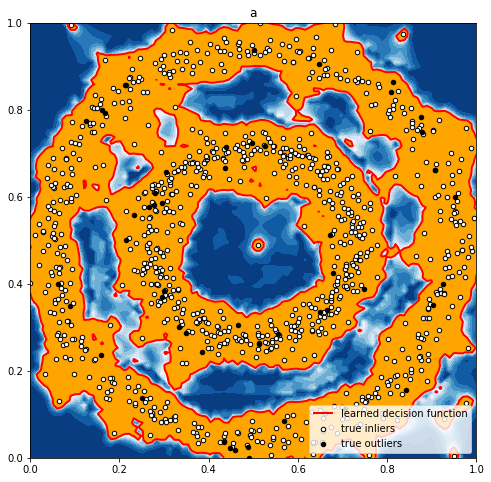

In [121]:
from pyod.models.abod import ABOD
outlier_fraction = 0.05
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

model = ABOD(contamination=outlier_fraction)
clf = model.fit(X_train)
scores_pred = clf.decision_function(X_train)*-1
y_pred = clf.predict(data_new)
threshold = stats.scoreatpercentile(scores_pred,100 *outlier_fraction)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

f = plt.figure(figsize=(8,8))
subplot = plt.subplot(1,1,1)

subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 10),cmap=plt.cm.Blues_r)
a = subplot.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',s=20, edgecolor='k') 
c = subplot.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c='black',s=20, edgecolor='k')
subplot.axis('tight')
subplot.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'true inliers', 'true outliers'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='lower right')

subplot.set_title('a')
subplot.set_xlim((0, 1))
subplot.set_ylim((0, 1))
plt.show()

## Execution Starts Here 

In [8]:
setup(data)

In [9]:
abod = create_model('abod')

In [10]:
assign_model(abod)

,0,1,2,3,4,5,6,7,8,9,Label,Score
0,0.263995,0.764929,0.138424,0.935242,0.605867,0.518790,0.912225,0.608234,0.723782,0.733591,1,-0.116896
1,0.546092,0.653975,0.065575,0.227772,0.845269,0.837066,0.272379,0.331679,0.429297,0.367422,0,-0.741534
2,0.336714,0.538842,0.192801,0.553563,0.074515,0.332993,0.365792,0.861309,0.899017,0.088600,0,-1.749890
3,0.092108,0.995017,0.014465,0.176371,0.241530,0.514724,0.562208,0.158963,0.073715,0.208463,1,-0.079959
4,0.325261,0.805968,0.957033,0.331665,0.307923,0.355315,0.501899,0.558449,0.885169,0.182754,0,-0.483633
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.305055,0.656837,0.331665,0.822525,0.907127,0.882276,0.855732,0.584786,0.808640,0.242762,0,-35.613792
996,0.812627,0.864258,0.616604,0.167966,0.811223,0.938071,0.418462,0.472306,0.348347,0.671129,0,-10.321261
997,0.250967,0.138627,0.919703,0.461234,0.886555,0.869888,0.800908,0.530324,0.779433,0.234952,0,-4.520541
998,0.502436,0.936820,0.580062,0.540773,0.151995,0.059452,0.225220,0.242755,0.279385,0.538755,0,-41.073435


In [29]:
new = pd.read_csv('anamoly.csv')
new = new.drop(['outlier'], axis=1)

In [43]:
predict_model(abod, new)

,0,1,2,3,4,5,6,7,8,9,Label,Score
0,0.263995,0.764929,0.138424,0.935242,0.605867,0.518790,0.912225,0.608234,0.723782,0.733591,1,-0.081687
1,0.546092,0.653975,0.065575,0.227772,0.845269,0.837066,0.272379,0.331679,0.429297,0.367422,1,-0.280524
2,0.336714,0.538842,0.192801,0.553563,0.074515,0.332993,0.365792,0.861309,0.899017,0.088600,1,-0.033833
3,0.092108,0.995017,0.014465,0.176371,0.241530,0.514724,0.562208,0.158963,0.073715,0.208463,1,-0.050515
4,0.325261,0.805968,0.957033,0.331665,0.307923,0.355315,0.501899,0.558449,0.885169,0.182754,0,-0.453683
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.305055,0.656837,0.331665,0.822525,0.907127,0.882276,0.855732,0.584786,0.808640,0.242762,0,-39.984156
996,0.812627,0.864258,0.616604,0.167966,0.811223,0.938071,0.418462,0.472306,0.348347,0.671129,0,-15.679793
997,0.250967,0.138627,0.919703,0.461234,0.886555,0.869888,0.800908,0.530324,0.779433,0.234952,0,-5.364130
998,0.502436,0.936820,0.580062,0.540773,0.151995,0.059452,0.225220,0.242755,0.279385,0.538755,0,-24.132628
